<a href="https://colab.research.google.com/github/tjs226/CSE-337_Lab5-NonLinearAprox/blob/main/Tedd_lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [188]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from gymnasium.wrappers import TimeLimit

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]


# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 5000
batch_size = 64
replay_buffer_size = 50000


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [189]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [190]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [191]:
def epsilon_greedy(state, epsilon):
  ############ TODO ###########
  if random.random() < epsilon: # random exploration
    return env.action_space.sample()
  else: # greedy (choose max reward)
    state_tensor = torch.FloatTensor(state).to(device).unsqueeze(0)
    with torch.no_grad():
      q_values = q_net(state_tensor)
      return torch.argmax(q_values).item()

In [192]:
def train_dqn():
    """Train the DQN using experience replay."""
    if len(replay_buffer) < batch_size: # dont have enough trials to update the Nural network
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    # makes them tennsors
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    # get the q values (predicted reward)
    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = q_net(next_states).max(1)[0].detach()
    targets = rewards + gamma * next_q_values * (1 - dones) # esitmated future reward

    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Episode 0, return=-200.0, epsilon=0.995
Episode 100, return=-200.0, epsilon=0.603
Episode 200, return=-200.0, epsilon=0.365
Episode 300, return=-200.0, epsilon=0.221
Episode 400, return=-116.0, epsilon=0.134
Episode 500, return=-153.0, epsilon=0.081
Episode 600, return=-159.0, epsilon=0.049
Episode 700, return=-115.0, epsilon=0.030
Episode 800, return=-91.0, epsilon=0.018
Episode 900, return=-116.0, epsilon=0.011
Episode 1000, return=-181.0, epsilon=0.010
Episode 1100, return=-106.0, epsilon=0.010
Episode 1200, return=-159.0, epsilon=0.010
Episode 1300, return=-183.0, epsilon=0.010
Episode 1400, return=-137.0, epsilon=0.010
Episode 1500, return=-105.0, epsilon=0.010
Episode 1600, return=-104.0, epsilon=0.010
Episode 1700, return=-111.0, epsilon=0.010
Episode 1800, return=-190.0, epsilon=0.010
Episode 1900, return=-103.0, epsilon=0.010
Episode 2000, return=-110.0, epsilon=0.010
Episode 2100, return=-104.0, epsilon=0.010
Episode 2200, return=-85.0, epsilon=0.010
Episode 2300, return=-170

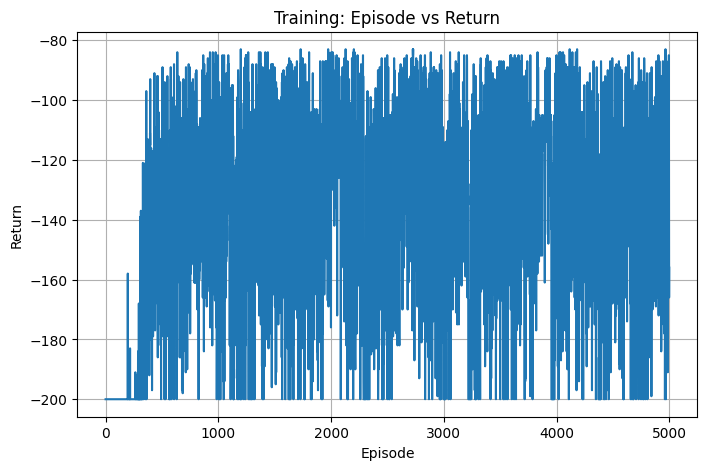

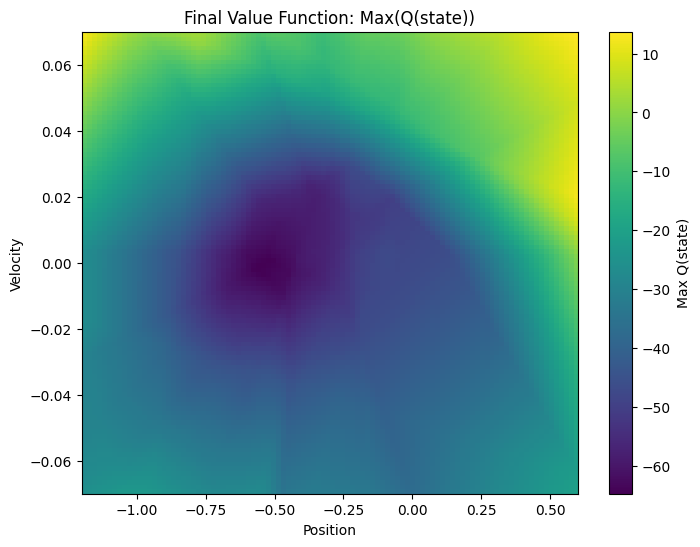

In [131]:
## Decaying Epsilon ##
rewards_dqn = []
steps_dqn = []  # track steps-to-goal per episode
returns_window = deque(maxlen=50)
epsilon = 1.0  # make sure epsilon starts at 1 each run

for episode in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0
    done = False
    steps = 0

    while not done:
        action = epsilon_greedy(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)  # unpack 5 values
        done = terminated or truncated  # stop if task ends or max steps reached
        replay_buffer.append((state, action, reward, next_state, done))
        train_dqn()
        state = next_state
        total_reward += reward
        steps += 1

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    rewards_dqn.append(total_reward)
    steps_dqn.append(steps)
    returns_window.append(total_reward)
    if (episode % 100 == 0):
        print(f"Episode {episode}, return={total_reward:.1f}, epsilon={epsilon:.3f}")

# print summary
avg_return = np.mean(rewards_dqn)
avg_steps = np.mean(steps_dqn)
print(f"Average steps-to-goal: {avg_steps:.2f}")
print(f"Average return: {avg_return:.2f}")

# Plot training performance
plt.figure(figsize=(8,5))
plt.plot(rewards_dqn)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Training: Episode vs Return")
plt.grid(True)
plt.show()


# plot final value function
positions = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 100)
velocities = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 100)
Z = np.zeros((len(positions), len(velocities)))

for i, pos in enumerate(positions):
    for j, vel in enumerate(velocities):
        state_tensor = torch.FloatTensor([pos, vel]).unsqueeze(0).to(device)
        with torch.no_grad():
            Z[i, j] = q_net(state_tensor).max(1)[0].item()

plt.figure(figsize=(8,6))
plt.imshow(
    Z.T,
    origin="lower",
    extent=[positions[0], positions[-1], velocities[0], velocities[-1]],
    aspect="auto",
    cmap="viridis"
)
plt.colorbar(label="Max Q(state)")
plt.title("Final Value Function: Max(Q(state))")
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.show()



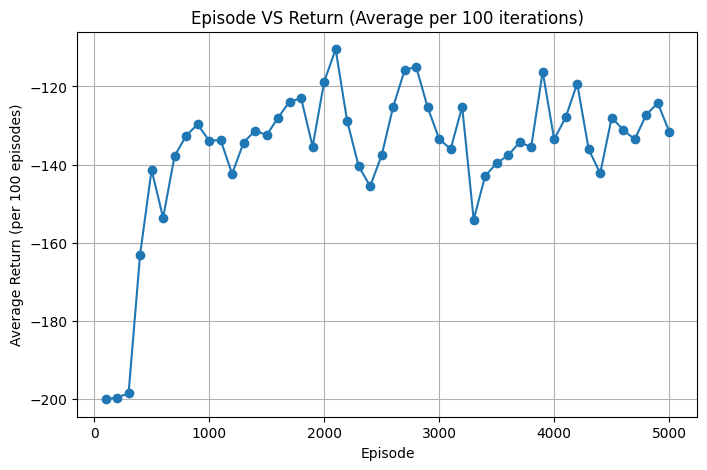

In [134]:
# the graph with 5000 iterations got too busy, so in this graph to plotted the average for every
# 100 iterations to make it more readable

# Compute average return for each 100-episode block
avg_returns_per_100 = [np.mean(rewards_dqn[i:i+100]) for i in range(0, len(rewards_dqn), 100)]

# X-axis: the episode number at the end of each block
x_axis = [i+100 for i in range(0, len(rewards_dqn), 100)]

# Plot
plt.figure(figsize=(8,5))
plt.plot(x_axis, avg_returns_per_100, marker='o')
plt.xlabel("Episode")
plt.ylabel("Average Return (per 100 episodes)")
plt.title("Episode VS Return (Average per 100 iterations)")
plt.grid(True)
plt.show()



Episode 0, return=-200.0
Episode 100, return=-96.0
Episode 200, return=-200.0
Episode 300, return=-128.0
Episode 400, return=-168.0
Episode 500, return=-127.0
Episode 600, return=-110.0
Episode 700, return=-165.0
Episode 800, return=-104.0
Episode 900, return=-109.0
Episode 1000, return=-177.0
Episode 1100, return=-161.0
Episode 1200, return=-94.0
Episode 1300, return=-108.0
Episode 1400, return=-123.0
Episode 1500, return=-175.0
Episode 1600, return=-169.0
Episode 1700, return=-122.0
Episode 1800, return=-161.0
Episode 1900, return=-98.0
Episode 2000, return=-104.0
Episode 2100, return=-112.0
Episode 2200, return=-196.0
Episode 2300, return=-191.0
Episode 2400, return=-152.0
Episode 2500, return=-192.0
Episode 2600, return=-96.0
Episode 2700, return=-153.0
Episode 2800, return=-118.0
Episode 2900, return=-148.0
Episode 3000, return=-168.0
Episode 3100, return=-188.0
Episode 3200, return=-187.0
Episode 3300, return=-138.0
Episode 3400, return=-129.0
Episode 3500, return=-172.0
Episode 

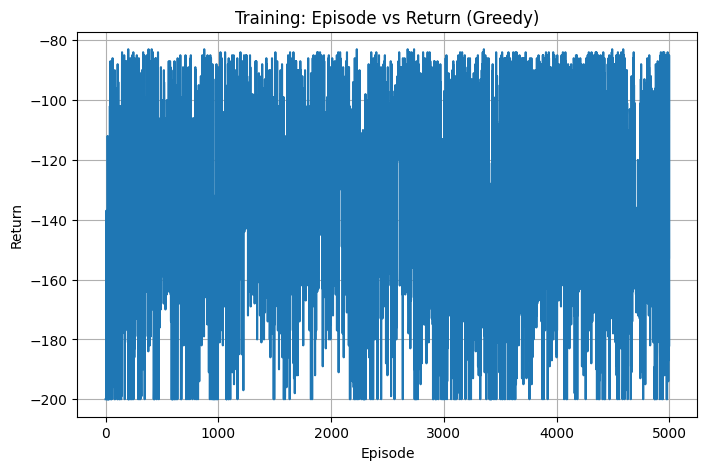

In [195]:
## Greedy Policy (epsilon = 0) ##
rewards_dqn = []
steps_dqn = []  # track steps-to-goal per episode
returns_window = deque(maxlen=50)

for episode in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0
    done = False
    steps = 0

    while not done:
        action = epsilon_greedy(state, epsilon=0)
        next_state, reward, terminated, truncated, _ = env.step(action)  # unpack 5 values
        done = terminated or truncated  # stop if task ends or max steps reached
        replay_buffer.append((state, action, reward, next_state, done))
        train_dqn()
        state = next_state
        total_reward += reward
        steps += 1


    rewards_dqn.append(total_reward)
    steps_dqn.append(steps)
    returns_window.append(total_reward)
    if (episode % 100 == 0):
        print(f"Episode {episode}, return={total_reward:.1f}")

# print summary
avg_return = np.mean(rewards_dqn)
avg_steps = np.mean(steps_dqn)
print(f"Average steps-to-goal: {avg_steps:.2f}")
print(f"Average return: {avg_return:.2f}")

# Plot training performance
plt.figure(figsize=(8,5))
plt.plot(rewards_dqn)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Training: Episode vs Return (Greedy)")
plt.grid(True)
plt.show()


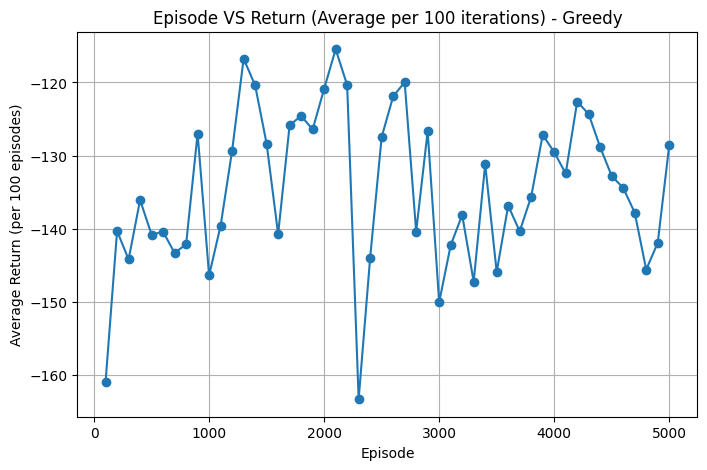

In [196]:
# the graph with 5000 iterations got too busy, so in this graph to plotted the average for every
# 100 iterations to make it more readable

# Compute average return for each 100-episode block
avg_returns_per_100 = [np.mean(rewards_dqn[i:i+100]) for i in range(0, len(rewards_dqn), 100)]

# X-axis: the episode number at the end of each block
x_axis = [i+100 for i in range(0, len(rewards_dqn), 100)]

# Plot
plt.figure(figsize=(8,5))
plt.plot(x_axis, avg_returns_per_100, marker='o')
plt.xlabel("Episode")
plt.ylabel("Average Return (per 100 episodes)")
plt.title("Episode VS Return (Average per 100 iterations) - Greedy")
plt.grid(True)
plt.show()


It would appear with the decaying epsilon it takes about 300 iterations to start learning. This method, in my opinion, does not always reach the goal reliably; sometimes it learns faster and other times much slower. I would think this is due to the complexity of neural networks. Tile coding looks like it runs faster and is more stable, and it would appear they even generalize better. With the neural network version, it did/would need more tuning with the learning rate as well as with epsilon; as it is now decaying, I think it could be better optimized for the number of trials we know we are running. If I had to choose one method or the other, I would choose tile coding, as they are computationally less expensive, learn faster, and in some ways are easier to understand, as neural networks become more like black boxes. However, we can't always "hand-craft" these features for all problems, so neural networks have a broader application.  It is also my obervation that a strictly greedy policy does not work well as you can see from the comparison above. It does not apear to be learning. The e - greedy policy with a decaying epsilon worked much better and did learn.

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


In [141]:
#pip install swig
#pip install "gymnasium[box2d]"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.2 MB/s eta 0:00:00


In [179]:
# Create the environment (just like mountain car)
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from gymnasium.wrappers import TimeLimit

# Set up environment
env = gym.make("LunarLander-v3")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 1000
batch_size = 64
replay_buffer_size = 50000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [180]:
# Define Q-Network (but now with 2 hiddin layes with 128 neurons each)
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [181]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)


In [182]:
def epsilon_greedy(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        state_tensor = torch.FloatTensor(state).to(device).unsqueeze(0)
        with torch.no_grad():
            q_values = q_net(state_tensor)
            return torch.argmax(q_values).item()

In [183]:
def train_dqn():
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    # Makes them tensors
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    # Get the q value (predicted reward)
    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = q_net(next_states).max(1)[0].detach()
    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Episode 0, return=-225.0, epsilon=0.995
Episode 10, return=-65.1, epsilon=0.946
Episode 20, return=-56.1, epsilon=0.900
Episode 30, return=-112.7, epsilon=0.856
Episode 40, return=-145.6, epsilon=0.814
Episode 50, return=-119.8, epsilon=0.774
Episode 60, return=-62.5, epsilon=0.737
Episode 70, return=-117.9, epsilon=0.701
Episode 80, return=-58.0, epsilon=0.666
Episode 90, return=-43.1, epsilon=0.634
Episode 100, return=-43.7, epsilon=0.603
Episode 110, return=-68.0, epsilon=0.573
Episode 120, return=-91.2, epsilon=0.545
Episode 130, return=-18.3, epsilon=0.519
Episode 140, return=19.9, epsilon=0.493
Episode 150, return=-46.4, epsilon=0.469
Episode 160, return=39.0, epsilon=0.446
Episode 170, return=50.8, epsilon=0.424
Episode 180, return=9.6, epsilon=0.404
Episode 190, return=-248.0, epsilon=0.384
Episode 200, return=-69.7, epsilon=0.365
Episode 210, return=198.3, epsilon=0.347
Episode 220, return=57.1, epsilon=0.330
Episode 230, return=-22.1, epsilon=0.314
Episode 240, return=-19.9, 

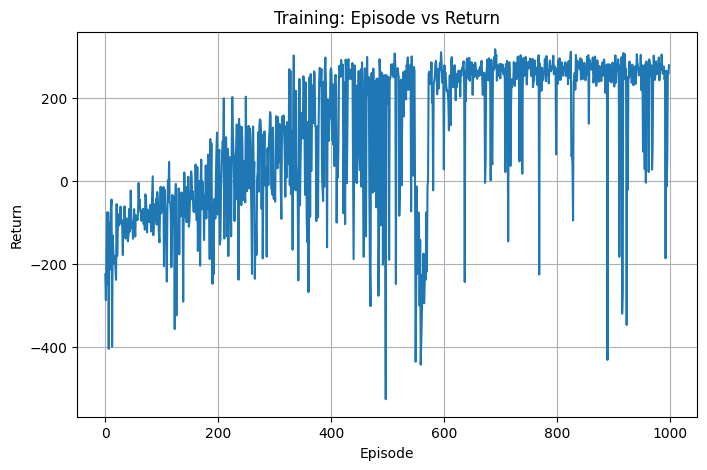

In [184]:
# Training Loop (with decaying epsilon like in mountain car)## Decaying Epsilon ##
# decaying epsilon
rewards_dqn = []
steps_dqn = []
returns_window = deque(maxlen=50)
epsilon = 1.0

for episode in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0
    done = False
    steps = 0

    while not done:
        action = epsilon_greedy(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.append((state, action, reward, next_state, done))
        train_dqn()
        state = next_state
        total_reward += reward
        steps += 1

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    rewards_dqn.append(total_reward)
    steps_dqn.append(steps)
    returns_window.append(total_reward)
    if (episode % 10 == 0):
        print(f"Episode {episode}, return={total_reward:.1f}, epsilon={epsilon:.3f}")

# Print summary
avg_return = np.mean(rewards_dqn)
avg_steps = np.mean(steps_dqn)
print(f"Average steps per episode: {avg_steps:.2f}")
print(f"Average return: {avg_return:.2f}")

# Plot training performance
plt.figure(figsize=(8,5))
plt.plot(rewards_dqn)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Training: Episode vs Return")
plt.grid(True)
plt.show()

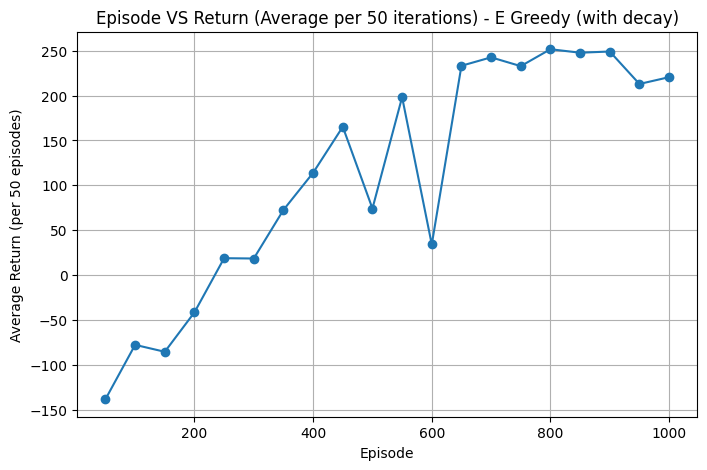

In [186]:
# the graph with 1000 iterations got too busy, so in this graph to plotted the average for every
# 50 iterations to make it more readable

# Compute average return for each 50-episode block
avg_returns_per_50 = [np.mean(rewards_dqn[i:i+50]) for i in range(0, len(rewards_dqn), 50)]

# X-axis: the episode number at the end of each block
x_axis = [i+50 for i in range(0, len(rewards_dqn), 50)]

# Plot
plt.figure(figsize=(8,5))
plt.plot(x_axis, avg_returns_per_50, marker='o')
plt.xlabel("Episode")
plt.ylabel("Average Return (per 50 episodes)")
plt.title("Episode VS Return (Average per 50 iterations) - E Greedy (with decay)")
plt.grid(True)
plt.show()


Episode 0, return=-61.5
Episode 10, return=-76.0
Episode 20, return=-37.7
Episode 30, return=-60.1
Episode 40, return=-63.9
Episode 50, return=3.4
Episode 60, return=-35.0
Episode 70, return=-44.5
Episode 80, return=-39.1
Episode 90, return=-35.5
Episode 100, return=-138.8
Episode 110, return=-25.7
Episode 120, return=-138.0
Episode 130, return=-188.4
Episode 140, return=-142.2
Episode 150, return=-159.2
Episode 160, return=-52.1
Episode 170, return=-25.7
Episode 180, return=-23.4
Episode 190, return=-124.1
Episode 200, return=-66.8
Episode 210, return=-12.1
Episode 220, return=-0.9
Episode 230, return=-11.2
Episode 240, return=196.5
Episode 250, return=230.7
Episode 260, return=-113.9
Episode 270, return=179.0
Episode 280, return=224.9
Episode 290, return=159.2
Episode 300, return=107.9
Episode 310, return=236.2
Episode 320, return=97.2
Episode 330, return=233.9
Episode 340, return=233.7
Episode 350, return=-13.6
Episode 360, return=265.4
Episode 370, return=242.1
Episode 380, return=

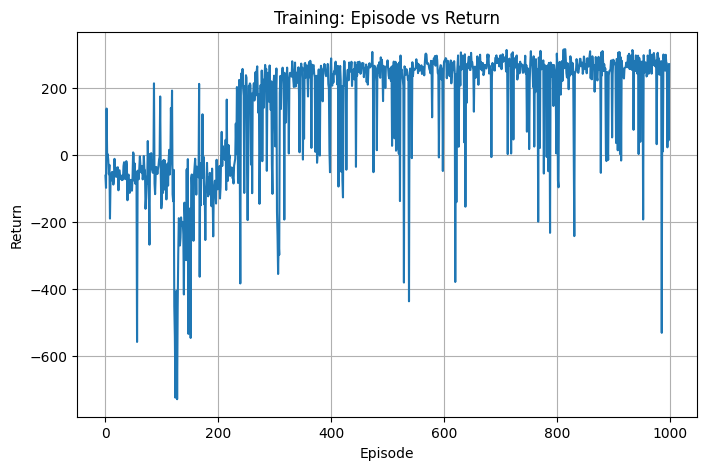

In [176]:
# Training Loop (with decaying epsilon like in mountain car)## Decaying Epsilon ##
# greedy policy (epsilon = 0 )
rewards_dqn = []
steps_dqn = []
returns_window = deque(maxlen=50)

for episode in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0
    done = False
    steps = 0

    while not done:
        action = epsilon_greedy(state, 0)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.append((state, action, reward, next_state, done))
        train_dqn()
        state = next_state
        total_reward += reward
        steps += 1

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    rewards_dqn.append(total_reward)
    steps_dqn.append(steps)
    returns_window.append(total_reward)
    if (episode % 10 == 0):
        print(f"Episode {episode}, return={total_reward:.1f}")

# Print summary
avg_return = np.mean(rewards_dqn)
avg_steps = np.mean(steps_dqn)
print(f"Average steps per episode: {avg_steps:.2f}")
print(f"Average return: {avg_return:.2f}")

# Plot training performance
plt.figure(figsize=(8,5))
plt.plot(rewards_dqn)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Training: Episode vs Return")
plt.grid(True)
plt.show()

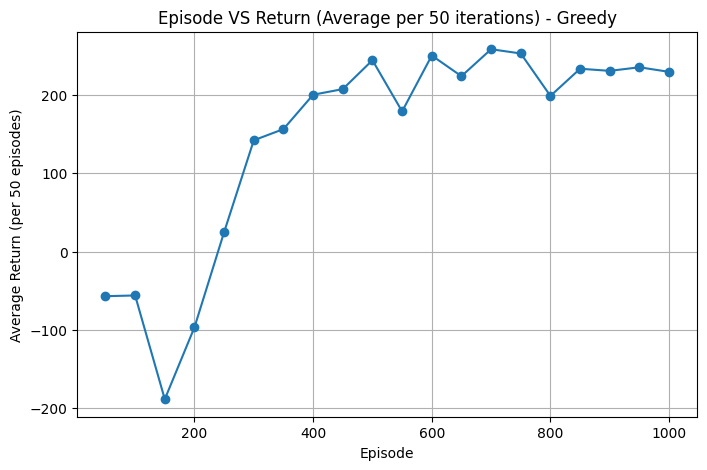

In [177]:
# the graph with 1000 iterations got too busy, so in this graph to plotted the average for every
# 50 iterations to make it more readable

# Compute average return for each 50-episode block
avg_returns_per_50 = [np.mean(rewards_dqn[i:i+50]) for i in range(0, len(rewards_dqn), 50)]

# X-axis: the episode number at the end of each block
x_axis = [i+50 for i in range(0, len(rewards_dqn), 50)]

# Plot
plt.figure(figsize=(8,5))
plt.plot(x_axis, avg_returns_per_50, marker='o')
plt.xlabel("Episode")
plt.ylabel("Average Return (per 50 episodes)")
plt.title("Episode VS Return (Average per 50 iterations) - Greedy")
plt.grid(True)
plt.show()



The Agent did learn to land very consistantly for most of the time. it took about 200 episodes before learning/ improvement was seen. For buffer size, if it was too small, it lead to too much training of the model and it lead to overfitting, causing the model no to premform well to certain cenarios. When it was higher it led to slower learning. For the target update frequencency, I observed that if too small, it slowed the learning down, and if it was too big, it made the agent unstable.  For the Learning rate, i found that if it was set too low, the model converged slower, and like the target update frequency, if set to high the model became unstable.  I think this task was about the same difficulty as the lunar lander, the neural networks simplify what the programmer needs to understand.  I think DQN may be needed here because we have too many factors that we could not represent well with titling, such as the state in the Mountain Car was 2D, while the state in the Lunar Lander is 8D making tilecoding imposible (or really just infeasable).  The Lunar Lander also has mixed rewards rather than just -1 per step like we saw in the mountain car.  In the case of Lunar Landing, exploration is diffucult and most explored paths resulting in a crash and only reveal landings in rare conditions.